# ROBOTICS FOCUS CONTROL

In [1]:
import torch
torch.manual_seed(38)
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import Normal
from torch.utils import data
from torchvision import transforms, utils
from awnet import pwc_5x5_sigmoid_bilinear   # cm:import AWnet model
from dep2def import depth2defocus
from functools import partial
import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [3]:
def get_parameter_number(net):
    '''
    print total and trainable number of params 
    '''
    total_num = sum(p.numel() for p in net.parameters())
    trainable_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    return {'Total': total_num, 'Trainable': trainable_num}

def dfs_freeze(model):
    '''
    freeze the network
    '''
    for name, child in model.named_children():
        for param in child.parameters():
            param.requires_grad = False
        dfs_freeze(child)

In [4]:
class focusLocNet(nn.Module):
    '''
    Description: analyze estimated ^J_{t-1} to get next focus position sampled from Gaussian distr.
    
    input: 
        x: (B, 3, 512, 896) image tensor
            range [-1, 1]

    output: 
        mu: (B, 1) mean of gaussian distribution
            range [-1, 1]
        pos: (B, 1) normalized focus position
            range [-1, 1]
        log_pi: logarithmatic probabilty of choosing pos ~ Gauss(mu, self.std)
        
    arguments:
        std: std of gaussian distribution
            
    '''
    
    def __init__(self, std = 0.17):
        super(focusLocNet, self).__init__()
        
        self.std = std
        
        self.block1 = convBlock(3, 16, 5, 2)
        self.block2 = convBlock(16, 32, 5, 2)
        self.block3 = convBlock(32, 32, 5, 2)
        self.block4 = convBlock(32, 64, 3, 2)
        self.block5 = convBlock(64, 64, 3, 2, isBn = False)        
#         self.block6 = convBlock(128, 128, 5, 4, isBn = False)
        self.fc0 = nn.Linear(1, 16)
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256+16, 256)
        self.fc3 = nn.Linear(256, 256)
        self.lstm = nn.LSTMCell(256, 128)
#         self.fc1 = nn.Linear(2304, 512)

        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 1)   
        
        self.init_hidden()
        
    def init_hidden(self):
        self.lstm_hidden = None
        return
        
    def forward(self, x, l_prev):
        x = self.block1(x)
        x = self.block2(x) 
        x = self.block3(x) 
        x = self.block4(x) 
        x = self.block5(x) 
#         x = self.block6(x)
        
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        y = F.relu(self.fc0(l_prev))
        x = torch.cat((x, y), dim = 1)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        if self.lstm_hidden is None:
            self.lstm_hidden = self.lstm(x)
        else:
            self.lstm_hidden = self.lstm(x, self.lstm_hidden)

#             self.h, self.c = self.lstm(x, (self.h, self.c))
        x = F.relu(self.lstm_hidden[0])
        
#         x = F.leaky_relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        x = F.relu(self.fc4(x))
        mu = torch.tanh(self.fc5(x))
        
        noise = torch.zeros_like(mu)
        noise.data.normal_(std=self.std)
        pos = mu + noise

        # bound between [-1, 1]
        pos = torch.tanh(pos)

        log_pi = Normal(mu, self.std).log_prob(pos)
        log_pi = torch.sum(log_pi, dim=1)
        
        return mu, pos, log_pi

class convBlock(nn.Module):
    '''
    Conv+ReLU+BN
    '''

    def __init__(self, in_feature, out_feature, filter_size, stride = 1, activation = F.relu, isBn = True):
        super(convBlock, self).__init__()
        self.isBn = isBn
        self.activation = activation

        self.conv1 = nn.Conv2d(in_feature, out_feature, filter_size, stride=stride)
        torch.nn.init.kaiming_normal_(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(out_feature)

    def forward(self, x):
        x = self.conv1(x)

        if self.activation is not None:
            x = self.activation(x)        
            
        if self.isBn:
            x = self.bn1(x)
        return x            

In [5]:
# # load pre-trained AWnet
AWnet = pwc_5x5_sigmoid_bilinear.pwc_residual().cuda()
AWnet.load_state_dict(torch.load('awnet/fs0_61_294481_0.00919393_dict.pkl'))

## freeze params of AWnet.
AWnet = AWnet.eval()

In [6]:
def reconsLoss(J_est, J_gt):   
    '''
    Calculate loss (neg reward) of Reinforcement learning
    
    input: 
        J_est: (B, Seq, C, H, W) predicted image sequences
        J_gt: (B, Seq, C, H, W) ground truth image sequence

    output: 
        lossTensor: (B, 1)
            mse value for each sequence of images in minibatch.
    '''
    lossList = []

    for i in range(J_gt.size()[0]):
        lossList.append(F.mse_loss(J_gt, J_est))
    
    lossTensor = torch.stack(lossList)
    return lossTensor
   
def getDefocuesImage(focusPos, J, dpt):
    '''
    Camera model. 
    Input: 
        focusPos Tensor(B, 1): current timestep focus position [-1, 1]
        J  Tensor (B, C, H, W): next time gt image [0, 1]
        dpt  Tensor (B, 1, H, W): J corresponding depth map [???]
    Output: 
        imageTensor (B, C, H, W): current timestep captured minibatch [0 1]
    '''
    width = 256
    f = 25
    fn = 4
    FoV_h = 10 * np.pi / 180
    pp = 2 * f * np.tan(FoV_h / 2) / width  # pixel pitch in mm
    gamma = 2.4
    # use partial is recommended to set lens parameter
    myd2d = partial(depth2defocus, f=f, fn=fn, pp=pp)  # this would fix f, fn, pp, and r_step
    imageTensor = []
    if use_cuda:
        focusPos, J, dpt = focusPos.cpu(), J.cpu(), dpt.cpu()

    for i in range(J.size()[0]):
        J_np = J[i].numpy().transpose(1, 2, 0)
        J_np = ((J_np+1)*127.5).astype(np.uint8)
        dpt_np = dpt[i].squeeze().numpy() * 1000.0
        focusPos_np = focusPos[i].squeeze().detach().numpy()*4000+5000
        # print(J_np.shape, dpt_np.shape, focusPos_np)
        focal_img = myd2d(J_np, dpt_np, focusPos_np, inpaint_occlusion=False)
        focal_img = focal_img/127.5-1
        focal_img = np.transpose(focal_img, (2, 0, 1))
        focal_img = torch.tensor(focal_img, device=device).float()
#         focal_img = torch.rand(J[i].size()) #......
        imageTensor.append(focal_img)
        
    imageTensor = torch.stack(imageTensor).to(device)
    
    return imageTensor

def fuseTwoImages(I, J_hat):
    '''
    AWnet fusion algorithm. 
    Input:
        I Tensor (B, C, H, W): current timestep captured minibatch
        J Tensor (B, C, H, W): last timestep fused minibatch
    Output:
        fusedTensor (B, C, H, W): current timestep fused minibatch
    '''
    with torch.no_grad():
        fusedTensor,warp,mask = AWnet(J_hat,I)
    return fusedTensor#, warp, mask

In [7]:
model = focusLocNet().to(device)
print(model)
get_parameter_number(model)

focusLocNet(
  (block1): convBlock(
    (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): convBlock(
    (conv1): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): convBlock(
    (conv1): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block4): convBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block5): convBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc0): Linear(in_features=1, out_features=16, bias=True)
  (fc1): Linear(in_featu

{'Total': 642369, 'Trainable': 642369}

In [8]:
# '''
# pseudo data test
# '''
# x = torch.rand(1, 3, 512, 896)
# mu, l, p = model(x)

In [9]:
from skimage import transform
from skimage.io import imread
class Dataset(data.Dataset):
    
    def __init__(self, gross, seq = 4, transform = None):
        self.gross = gross
        self.seq = seq
        self.transform = transform
        
    def __len__(self):
        return self.gross
    
    def __getitem__(self, index):
        
        # shape: (Seq, C, H, W)
        # X = torch.rand(self.seq , 3, 128, 256)
        # dpt = torch.rand(self.seq, 1, 128, 256)
        X = []
        dpt = []
        for i in range(self.seq):
            img = imread("../datasets/DAVIS/JPEGImages/bear/{:05d}.jpg".format(index + i*3))
            img = np.float32(img)/127.5-1
            img = transform.resize(img, (64, 128))
            X.append(img.transpose(2, 0, 1))
            d = np.load("../datasets/DAVIS/viz_predictions/bear/{:05d}.npy".format(index + i*3))
            d = transform.resize(d, (64, 128))
            dpt.append(d)
            
        X = np.stack(X)
        dpt = np.stack(dpt)
        
        return (X, dpt)
    
'''
Generate pseudo data for training.
'''    

dataset = Dataset(21, transform = transforms.Compose([
        transforms.ToTensor()]))
        #transforms.Normalize(mean=[0.485, 0.456, 0.406],
         #                        std=[0.229, 0.224, 0.225])]))

params = {'batch_size':1, 'shuffle':True, 'num_workers':4}
dataGenerator = data.DataLoader(dataset, **params)

torch.Size([1, 4, 3, 64, 128])


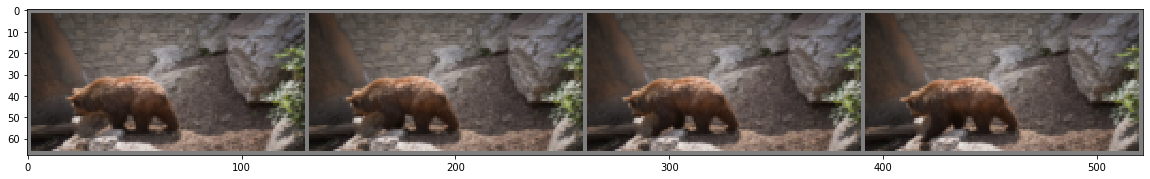

In [10]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataGenerator)
images, labels = dataiter.next()
print(images.size())
imshow(utils.make_grid(images[0]))

tensor([[-0.9610],
        [-0.4455],
        [ 0.9979],
        [-0.0375]])


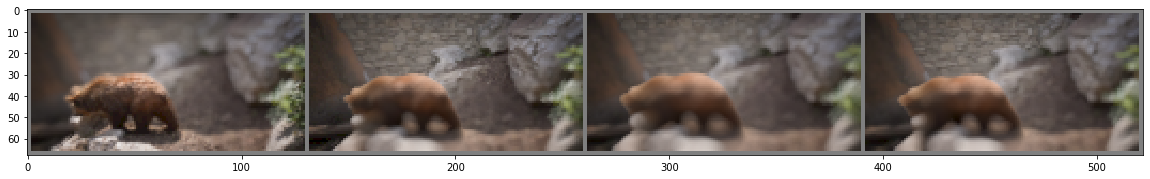

In [12]:
loc = torch.rand(4, 1)*2-1
print(loc)
imgT = getDefocuesImage(loc.cuda(),images[0].cuda(),labels[0].cuda())
imshow(utils.make_grid(imgT.cpu()))

In [ ]:
optim = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

In [ ]:
def train_one_epoch(dataGenerator, optimizer):
    
    training_loss = 0
    
    for i, (y_train, dpt) in enumerate(dataGenerator):

        print("--------episode {}----------".format(i+1))
        y_train = y_train.to(device)
        dpt = dpt.to(device)
        
        optimizer.zero_grad()
        # data shape: y_train (B, Seq, C, H, W)
        log_pi = []
        J_est = []
        J_prev = y_train[:, 0, ...] ## set J_prev to be first frame of the image sequences
        J_est.append(J_prev)
        I = y_train[:, 0, ...]
        l = torch.rand(1, 1, device = device)*2-1
        l_est = []
        l_est.append(l)
        
        for t in range(y_train.size()[1]-1):
            # for each time step: estimate, capture and fuse.
            print("timestep {}: ".format(t+1), end='')
            mu, l, p = model(I, l)
            log_pi.append(p)
            I = getDefocuesImage(l, y_train[:, t+1, ...], dpt[:, t+1, ...])
            J_prev = fuseTwoImages(I, J_prev)
            J_est.append(J_prev)
            l_est.append(l)
            print("{:.2f}".format(l.item()))
            
        J_est = torch.stack(J_est, dim = 1)
        
        log_pi = torch.stack(log_pi).transpose(1, 0)
        R = -reconsLoss(J_est, y_train)
        R = R.unsqueeze(1).repeat(1, y_train.size()[1]-1)
        
        ## Basic REINFORCE algorithm
        loss = torch.sum(-log_pi*R, dim=1)
        loss = torch.mean(loss, dim=0)
        
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()
        
        model.init_hidden()
        
    print("training_loss: ", training_loss / i)
        

In [ ]:
# import time
# start_time = time.time()
for i in range(10):
    print("epoch", i+1)
    train_one_epoch(dataGenerator, optim)
# print("avg time of 100 epoches: {:.3f}s".format((time.time()-start_time)/100.))